# H-1B Prediction
Classification of "CASE_STATUS"

In [70]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn import metrics 
from sklearn.decomposition import PCA
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import scipy
from time import time
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

## Exploring the Data

In [71]:
# The data set consists of abount 3,000,000 rows.
# Reading 10% of the dataset, randomly...
n = 10  # every 10th line
data = pd.read_csv("h1b_kaggle.csv", engine="python", skiprows=lambda i: i % n != 0, index_col=0)

In [72]:
# Keep in mind that this is about 10% of the total amount of cases in the originl dataset. I did this for efficiency.
print('Total H1B cases:',data.shape[0])

Total H1B cases: 300245


In [73]:
data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
10,WITHDRAWN,LESSARD INTERNATIONAL LLC,CHIEF EXECUTIVES,PRESIDENT,Y,154648.00,2016.0,"VIENNA, VIRGINIA",-77.265260,38.901222
20,CERTIFIED,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,"PRESIDENT, NORTHEAST REGION",Y,241842.00,2016.0,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835
30,CERTIFIED,"PERSPECTIVES OF FREEDOM FOUNDATION, INC",CHIEF EXECUTIVES,EXECUTIVE DIRECTOR,Y,95295.98,2016.0,"WESTON, FLORIDA",-80.399775,26.100365
40,DENIED,"PARALLELS, INC.",CHIEF EXECUTIVES,CHIEF EXECUTIVE OFFICER,Y,187200.00,2016.0,"RENTON, WASHINGTON",-122.217066,47.482878
50,CERTIFIED,RANCHO LA PUERTA LLC,CHIEF EXECUTIVES,PRESIDENT,Y,197683.20,2016.0,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738


In [74]:
# Distinct CASE_STATUS values.
data.CASE_STATUS.unique()

array(['WITHDRAWN', 'CERTIFIED', 'DENIED', 'CERTIFIED-WITHDRAWN',
       'REJECTED', 'INVALIDATED',
       'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED', nan],
      dtype=object)

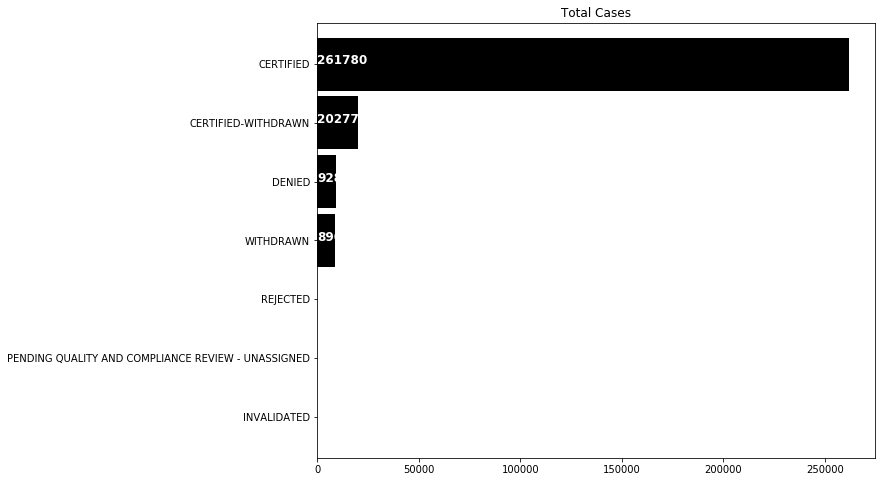

In [75]:
plt.figure(figsize=(10,8))
ax=data['CASE_STATUS'].value_counts().sort_values(ascending=True).plot.barh(width=0.9,color='black')
for i, v in enumerate(data['CASE_STATUS'].value_counts().sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Total Cases')
plt.show()

## Cleaning up the data

#### From the figure above, we should remove rejected, invalidated, pending review, withdrawn, certified-withdrawn applications. They were removed to leave only two classification results : Certified and Denied, since this is my main focus to predict. 

In [76]:
data = data[data['CASE_STATUS'] != 'REJECTED']  
data = data[data['CASE_STATUS'] != 'INVALIDATED']  
data = data[data['CASE_STATUS'] != 'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED']  
data = data[data['CASE_STATUS'] != 'WITHDRAWN'] 
data = data[data['CASE_STATUS'] != 'CERTIFIED-WITHDRAWN'] 

# limiting to remove outlier wages above 1,000,000 
data.reset_index(drop=True, inplace=True)
data = data[(data['PREVAILING_WAGE'] < 1000000)]

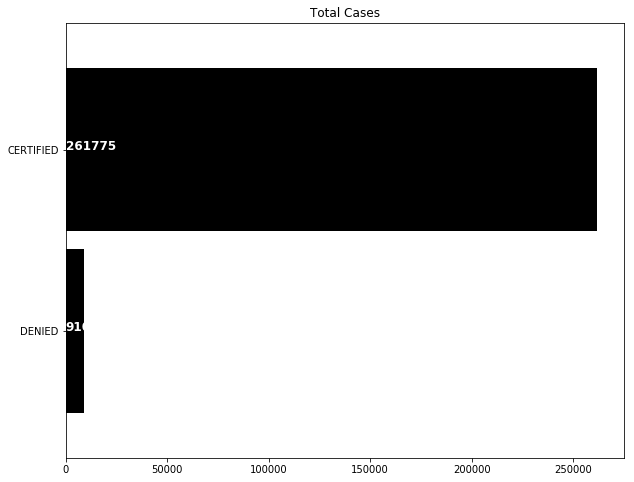

In [77]:
plt.figure(figsize=(10,8))
ax=data['CASE_STATUS'].value_counts().sort_values(ascending=True).plot.barh(width=0.9,color='black')
for i, v in enumerate(data['CASE_STATUS'].value_counts().sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Total Cases')
plt.show()

## Visualizing the Data

#### Showing how many H1-B Applications filed per year from 2011 to 2016

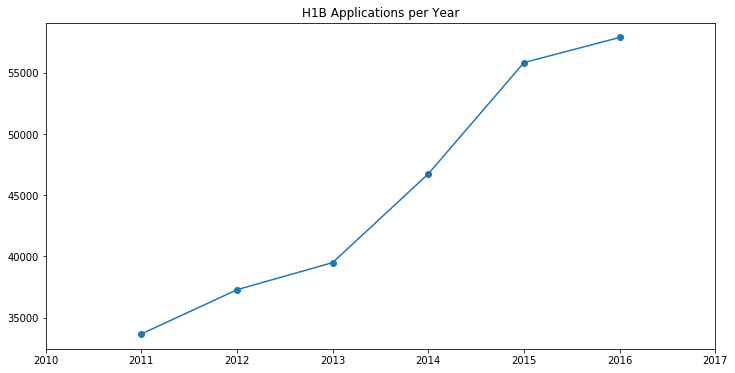

In [78]:
plt.figure(figsize=(12,6))
data['YEAR'].value_counts().sort_values().plot(marker='o')
plt.title('H1B Applications per Year')
plt.xlim([2010,2017])
plt.show()

#### Showing Which employer has the highest petitions filed each year


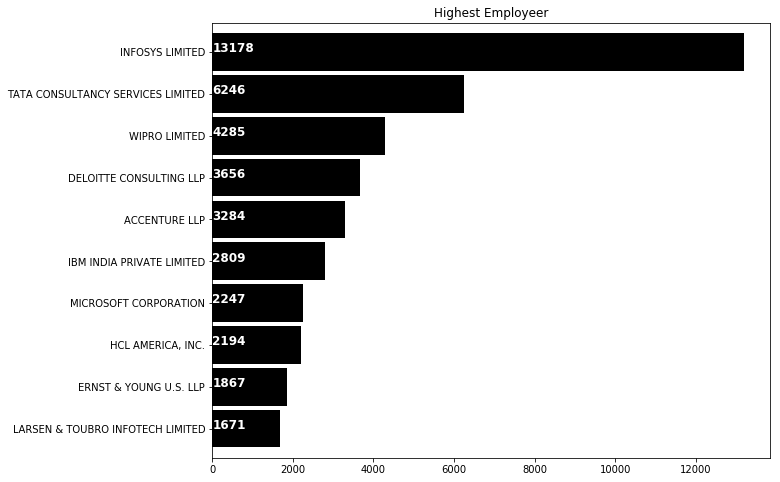

In [79]:
plt.figure(figsize=(10,8))
ax=data['EMPLOYER_NAME'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.9,color='black')
for i, v in enumerate(data['EMPLOYER_NAME'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Highest Employeer')
fig=plt.gca()
fig.invert_yaxis()
plt.show()

In [80]:
# Features & outcome 
classifier = data['CASE_STATUS']
classfiee = data.drop(['CASE_STATUS','EMPLOYER_NAME','JOB_TITLE', 'lon', 'lat', 'WORKSITE'], axis = 1)
classfiee.head(1)

,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR
0,CHIEF EXECUTIVES,Y,241842.0,2016.0


#### Showing the amount applications filed based on location


Number of applications grouped by worksite:

 NEW YORK, NEW YORK           17228
HOUSTON, TEXAS                7566
SAN FRANCISCO, CALIFORNIA     5552
ATLANTA, GEORGIA              4794
CHICAGO, ILLINOIS             4657
Name: WORKSITE, dtype: int64


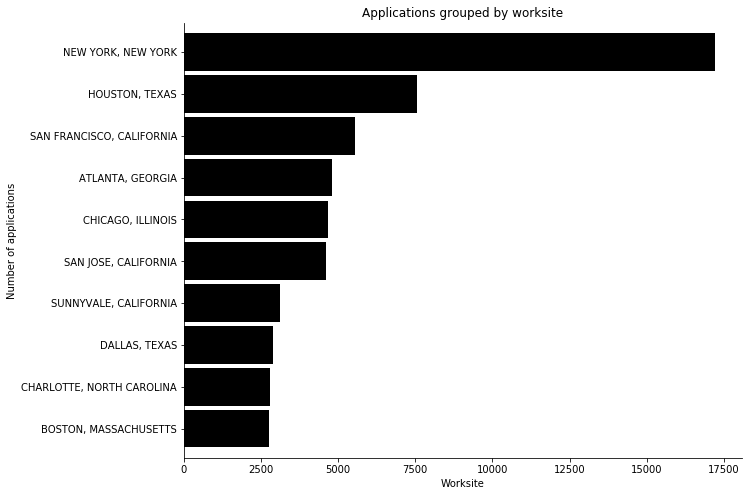

In [81]:
worksite = data['WORKSITE'].value_counts()
print('\nNumber of applications grouped by worksite:\n\n', worksite.head(5))
plt.figure(figsize=(10,8))
ax = worksite.head(10).plot(kind='barh', width=0.9, stacked=True, title='Applications grouped by worksite', color='black')
fig=plt.gca()
fig.invert_yaxis()
ax.set_xlabel("Worksite")
ax.set_ylabel('Number of applications')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Showing the count of applications by job title



Number of applications by job title:

 PROGRAMMER ANALYST     22706
SOFTWARE ENGINEER      10526
COMPUTER PROGRAMMER     6503
SYSTEMS ANALYST         5618
SOFTWARE DEVELOPER      3932
Name: JOB_TITLE, dtype: int64


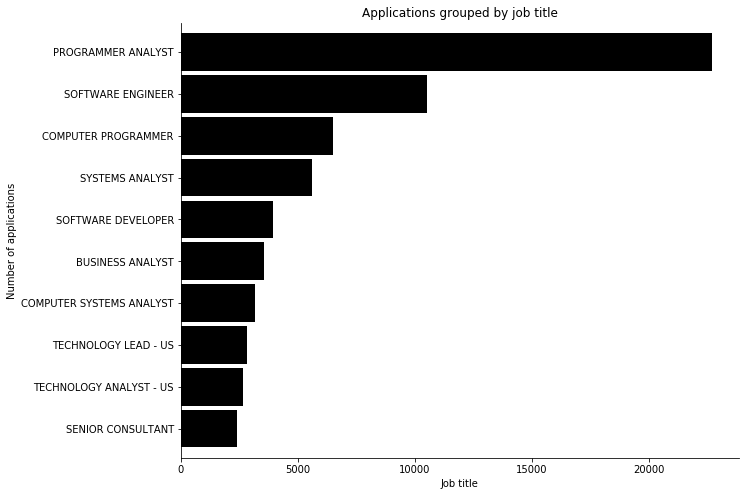

In [82]:
job_title = data['JOB_TITLE'].value_counts()
print('\nNumber of applications by job title:\n\n', job_title.head(5))

plt.figure(figsize=(10,8))
ax = job_title.head(10).plot(kind='barh', width=0.9, stacked=True, title='Applications grouped by job title', color='black')
fig=plt.gca()
fig.invert_yaxis()
ax.set_xlabel("Job title")
ax.set_ylabel('Number of applications')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Showing some statistical analysis regarding the wages range within the applicants

In [83]:
print("Statistics for H1-B Visa Applications:\n")
print("Minimum wage: ${:,.2f}".format(min(classfiee['PREVAILING_WAGE'])))
print("Maximum wage: ${:,.2f}".format(max(classfiee['PREVAILING_WAGE'])))
print("Mean wage: ${:,.2f}".format(np.mean(classfiee['PREVAILING_WAGE'])))
print("Median wage ${:,.2f}".format(np.median(classfiee['PREVAILING_WAGE'])))
print("Standard deviation of wage: ${:,.2f}".format(np.std(classfiee['PREVAILING_WAGE'])))

Statistics for H1-B Visa Applications:

Minimum wage: $0.00
Maximum wage: $952,728.00
Mean wage: $70,514.77
Median wage $65,042.00
Standard deviation of wage: $26,839.16


## Preparing the data for Classification

#### One Hot Encoding


In [84]:
classifier = classifier.apply(lambda x: 1 if x == 'CERTIFIED' else x)
classifier = classifier.apply(lambda x: 2 if x == 'DENIED' else x)

converted = pd.get_dummies(classfiee)

encoded = list(converted.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

1238 total features after one-hot encoding.


In [85]:
classifier.head()

0    1
1    1
2    2
3    1
4    1
Name: CASE_STATUS, dtype: int64

In [147]:
converted.head()

,PREVAILING_WAGE,YEAR,SOC_NAME_ACCOUNTANTS,SOC_NAME_ACCOUNTANTS AND AUDITORS,SOC_NAME_ACTUARIES,SOC_NAME_ADMINISTRATIVE SERVICES MANAGERS,SOC_NAME_ADULT BASIC AND SECONDARY EDUCATION AND LITERACY,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGER,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGERS,SOC_NAME_ADVERTISING SALES AGENTS,...,SOC_NAME_Web Administrators,SOC_NAME_Web Developers,"SOC_NAME_Welders, Cutters, Solderers, and Brazers","SOC_NAME_Wholesale and Retail Buyers, Except Farm Products","SOC_NAME_Woodworkers, All Other",SOC_NAME_Writers and Authors,SOC_NAME_ZOOLOGISTS AND WILDLIFE BIOLOGISTS,SOC_NAME_Zoologists and Wildlife Biologists,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y
0,241842.00,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,95295.98,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,187200.00,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,197683.20,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,187075.00,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [87]:
dict = {1:0, 2:1}

class1 = classifier.map(dict)

In [88]:
class1.head()

0    0
1    0
2    1
3    0
4    0
Name: CASE_STATUS, dtype: int64

#### Splitting the data into training and testing sets


In [123]:
X_train, X_test, y_train, y_test = train_test_split(converted, class1, test_size=0.2, random_state=11)

print("Training set = {} samples.".format(X_train.shape[0]))
print("Testing set = {} samples.".format(X_test.shape[0]))

Training set = 216704 samples.
Testing set = 54177 samples.


#### Creating a Training and Predicting Pipeline 


In [90]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    results = {}
    learner = learner.fit(X_train, y_train)
    
    # Getting the predictions on the test set & on the first 10% of the training samples 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
        
    #results['accuracy_test'] = round(accuracy_score(y_test, predictions_test), 5)
    print("Accuracy Score: \n", round(accuracy_score(y_test, predictions_test), 5))

    #results['confusion_matrix_test'] = confusion_matrix(y_test, predictions_test)
    print("Confusion Matrix: \n", confusion_matrix(y_test, predictions_test))
   
    #results['classification_report_test'] = classification_report(y_test, predictions_test)
    print('Classification Report: \n', classification_report(y_test, predictions_test))
    
    
    #results['roc_auc_score_test'] = round(roc_auc_score(y_test, predictions_test), 5)
    print('roc_auc_score_test: \n', round(roc_auc_score(y_test, predictions_test),5))

    # the print statements for each method results are used to make the display of outputs look better and more presentable. 
    return results
    


## Classification Time

### 1- Bayesian Classification


In [91]:
bc = GaussianNB()
train_predict(bc, X_train, y_train, X_test, y_test)

Accuracy Score: 
 0.95705
Confusion Matrix: 
 [[51786   625]
 [ 1702    64]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      0.99      0.98     52411
          1       0.09      0.04      0.05      1766

avg / total       0.94      0.96      0.95     54177

roc_auc_score_test: 
 0.51216


{}

### 2-Logistic Regression

In [92]:
lr = LogisticRegression()
train_predict(lr, X_train, y_train, X_test, y_test)

Accuracy Score: 
 0.9674
Confusion Matrix: 
 [[52411     0]
 [ 1766     0]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.98     52411
          1       0.00      0.00      0.00      1766

avg / total       0.94      0.97      0.95     54177

roc_auc_score_test: 
 0.5


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{}

### 3-Gausian NB


In [93]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
train_predict(gnb, X_train, y_train, X_test, y_test)



Accuracy Score: 
 0.95705
Confusion Matrix: 
 [[51786   625]
 [ 1702    64]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      0.99      0.98     52411
          1       0.09      0.04      0.05      1766

avg / total       0.94      0.96      0.95     54177

roc_auc_score_test: 
 0.51216


{}

### 4- Random Forest


In [94]:
from sklearn.ensemble import RandomForestClassifier
model_RF=RandomForestClassifier()
train_predict(model_RF, X_train, y_train, X_test, y_test)


Accuracy Score: 
 0.95618
Confusion Matrix: 
 [[51676   735]
 [ 1639   127]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      0.99      0.98     52411
          1       0.15      0.07      0.10      1766

avg / total       0.94      0.96      0.95     54177

roc_auc_score_test: 
 0.52895


{}

### Comparison Summary and Conclusion

#### These are the false positives and false negatives respectively presented


In [95]:
Random_forest = (717, 1654)
Gausian_NB = (625, 1702)
Logistic_Reg = (0, 1766) # has zero false positives, and also the highest accuracy rate of 0.9674
Baisian = (625, 1702)


#### When comparing the four different classification methods, they all seem to have high accuracy rates and similar AUC score tests, while they all had different confusion matrix results, which had me decide to use it as a factor to distinguish which method is the best for this data set. 
#### Looking at the confusion matrices, It turns out that the Logistic Regression model provides the best results, because what distinguishes it from other models is that fact that it shows zero false positives. This means that it never predicted false application statuses in terms of them being certified. Although this model has some false negatives, it does not have any false positives, which is more valuable since the applicant would rather know that their application was accurately classified and denied, than have false positives and get excited that they got certified and then realized that it was false positive news. Therefore it is believed that logistic regression provides is found to be more reliable and accurate, especially that it has the highest accuracy score  from the other classification methods used. 

## Further Analysis (Homework Assignment)


In [116]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    results = {}
    learner.fit(X_train, y_train)
    

    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
   
    print("Accuracy Score: \n", round(accuracy_score(y_test, predictions_test), 5))

    print("Confusion Matrix: \n", confusion_matrix(y_test, predictions_test))
   
    print('Classification Report: \n', classification_report(y_test, predictions_test))
      
    print('roc_auc_score_test: \n', round(roc_auc_score(y_test, predictions_test),5))

    return predictions_test, predictions_train
    

#### Looking at the incorrectly classified results in the testing set and using Logistic Regression since I choose it to be the best classification model. I want to explore the false classification it had and explore them further. 


In [97]:
lr = LogisticRegression()
saved_test,saved_train = train_predict(lr, X_train, y_train, X_test, y_test)


Accuracy Score: 
 0.9674
Confusion Matrix: 
 [[52411     0]
 [ 1766     0]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.98     52411
          1       0.00      0.00      0.00      1766

avg / total       0.94      0.97      0.95     54177

roc_auc_score_test: 
 0.5


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### I decided to stick with the testing set and apply my further analysis and exploration on. 


In [121]:
# Creating a modified x test to add new columns to identify the false classifications
modified_x_test = X_test.copy()

In [155]:
X_test.head()

,PREVAILING_WAGE,YEAR,SOC_NAME_ACCOUNTANTS,SOC_NAME_ACCOUNTANTS AND AUDITORS,SOC_NAME_ACTUARIES,SOC_NAME_ADMINISTRATIVE SERVICES MANAGERS,SOC_NAME_ADULT BASIC AND SECONDARY EDUCATION AND LITERACY,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGER,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGERS,SOC_NAME_ADVERTISING SALES AGENTS,...,SOC_NAME_Web Administrators,SOC_NAME_Web Developers,"SOC_NAME_Welders, Cutters, Solderers, and Brazers","SOC_NAME_Wholesale and Retail Buyers, Except Farm Products","SOC_NAME_Woodworkers, All Other",SOC_NAME_Writers and Authors,SOC_NAME_ZOOLOGISTS AND WILDLIFE BIOLOGISTS,SOC_NAME_Zoologists and Wildlife Biologists,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y
122669,162219.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
151953,88130.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36852,114504.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
63389,108098.0,2015.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
22593,51730.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [99]:
# Adding the Actual status column
modified_x_test['Actual_Status'] = y_test 

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [156]:
modified_x_test.head()

,PREVAILING_WAGE,YEAR,SOC_NAME_ACCOUNTANTS,SOC_NAME_ACCOUNTANTS AND AUDITORS,SOC_NAME_ACTUARIES,SOC_NAME_ADMINISTRATIVE SERVICES MANAGERS,SOC_NAME_ADULT BASIC AND SECONDARY EDUCATION AND LITERACY,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGER,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGERS,SOC_NAME_ADVERTISING SALES AGENTS,...,"SOC_NAME_Welders, Cutters, Solderers, and Brazers","SOC_NAME_Wholesale and Retail Buyers, Except Farm Products","SOC_NAME_Woodworkers, All Other",SOC_NAME_Writers and Authors,SOC_NAME_ZOOLOGISTS AND WILDLIFE BIOLOGISTS,SOC_NAME_Zoologists and Wildlife Biologists,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y,Actual_Status,Predicted_Status
122669,162219.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
151953,88130.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
36852,114504.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
63389,108098.0,2015.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22593,51730.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [101]:
# Adding the Predicted Status column
modified_x_test['Predicted_Status'] = saved_test 

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
modified_x_test.head()

,PREVAILING_WAGE,YEAR,SOC_NAME_ACCOUNTANTS,SOC_NAME_ACCOUNTANTS AND AUDITORS,SOC_NAME_ACTUARIES,SOC_NAME_ADMINISTRATIVE SERVICES MANAGERS,SOC_NAME_ADULT BASIC AND SECONDARY EDUCATION AND LITERACY,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGER,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGERS,SOC_NAME_ADVERTISING SALES AGENTS,...,"SOC_NAME_Welders, Cutters, Solderers, and Brazers","SOC_NAME_Wholesale and Retail Buyers, Except Farm Products","SOC_NAME_Woodworkers, All Other",SOC_NAME_Writers and Authors,SOC_NAME_ZOOLOGISTS AND WILDLIFE BIOLOGISTS,SOC_NAME_Zoologists and Wildlife Biologists,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y,Actual_Status,Predicted_Status
122669,162219.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
151953,88130.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
36852,114504.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
63389,108098.0,2015.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22593,51730.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
# Identifying false classifications within the model 
false_classification = modified_x_test.query('Actual_Status != Predicted_Status')

In [146]:
false_classification.head()

,PREVAILING_WAGE,YEAR,SOC_NAME_ACCOUNTANTS,SOC_NAME_ACCOUNTANTS AND AUDITORS,SOC_NAME_ACTUARIES,SOC_NAME_ADMINISTRATIVE SERVICES MANAGERS,SOC_NAME_ADULT BASIC AND SECONDARY EDUCATION AND LITERACY,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGER,SOC_NAME_ADVERTISING AND PROMOTIONS MANAGERS,SOC_NAME_ADVERTISING SALES AGENTS,...,"SOC_NAME_Welders, Cutters, Solderers, and Brazers","SOC_NAME_Wholesale and Retail Buyers, Except Farm Products","SOC_NAME_Woodworkers, All Other",SOC_NAME_Writers and Authors,SOC_NAME_ZOOLOGISTS AND WILDLIFE BIOLOGISTS,SOC_NAME_Zoologists and Wildlife Biologists,FULL_TIME_POSITION_N,FULL_TIME_POSITION_Y,Actual_Status,Predicted_Status
122669,162219.0,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
55289,49462.0,2016.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
240832,52894.0,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
242076,26478.4,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
268178,41808.0,2011.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


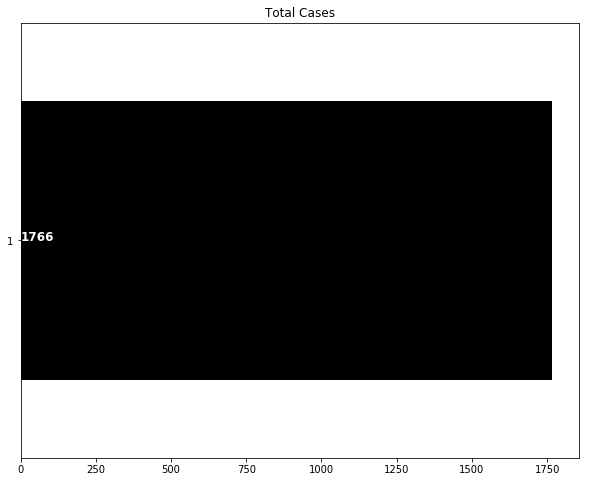

In [105]:
plt.figure(figsize=(10,8))
ax=false_classification['Actual_Status'].value_counts().sort_values(ascending=True).plot.barh(width=0.9,color='black')
for i, v in enumerate(false_classification['Actual_Status'].value_counts().sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Total Cases')
plt.show()

### This shows that every time the classifier was wrong, it was showing a false negative amount if 1766. 


### Comparison between false and correct classifications

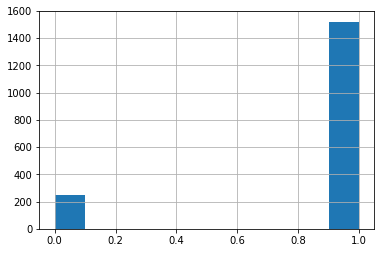

In [154]:
# Looking at the full time positions in the false classification data
false_classification.FULL_TIME_POSITION_Y.hist()

In [151]:
correct_classification = modified_x_test.query('Actual_Status == Predicted_Status')

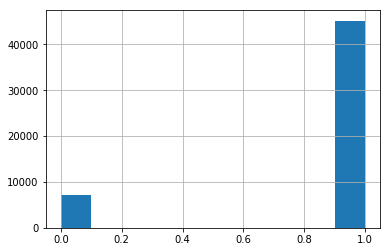

In [152]:
# looking at the full time positions in the correct data classification 
correct_classification.FULL_TIME_POSITION_Y.hist()

#### By just looking at the Y axis, there is a huge change between the correct and false classified data in terms of full time positions.

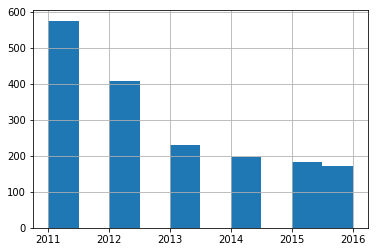

In [159]:
# Looking at the year in the false classification data
false_classification.YEAR.hist()

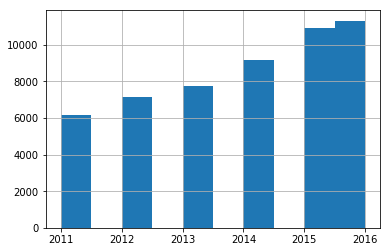

In [160]:
# looking at the year in the correct data classification 
correct_classification.YEAR.hist()

#### It is clear that the false classifications are decreasing over time, and the correct classifications are increasing. This is a good sign and shows that the classification model has improved over the years. It can also be perceived that the administration that oversees the H1-B application has implemented a more consistant method overtime. Therefore the classification model was able to predict better results over time. 

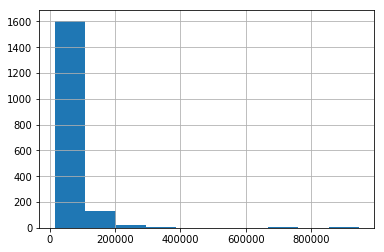

In [161]:
# Looking at the prevailing wage in the false classification data
false_classification.PREVAILING_WAGE.hist()

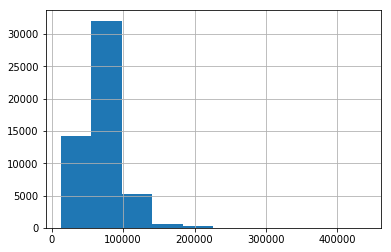

In [165]:
# looking at the prevailing wage in the correct data classification 
correct_classification.PREVAILING_WAGE.hist()

### Overall, the Correct and false classification were similar to an extent that they did not offer a trigger for further exploration. There was a change in the years, but in terms of wages and full time distribution, the change was not significant.  

## 2- Using GridSearchCV class to try to find the best values for the hyperparameters for logistic regression.

In [107]:
#2 Hyperparameter (Choosing Logistic Regression) using GridSearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'warm_start':[True,False], 'dual':[True,False]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters)
clf.fit(X_test, y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'dual': [True, False], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [108]:
clf.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'ovr',
 'estimator__n_jobs': 1,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': None,
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'dual': [True, False], 'warm_start': [True, False]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': None,
 'verbose': 0}

In [109]:
tuned_prediction= clf.predict(X_test)

In [110]:
 print("Accuracy Score: \n", round(accuracy_score(y_test, tuned_prediction), 5))

Accuracy Score: 
 0.9674


### No improvements, the accuracy score is the same as before, therefore Hypterparameter does not offer any help. 

## 3- Using the Ensemble Idea to see if it might imrpove my results

In [126]:
#3 Ensembles 
class ensemble_classifier:
    def __init__(self):
        self.nb = GaussianNB()
        self.lr = LogisticRegression()
        self.rf = RandomForestClassifier()
        
    def fit(self, X_train, y_train):
        self.nb.fit(X_train, y_train)
        self.lr.fit(X_train, y_train)
        self.rf.fit(X_train, y_train)
    
    def predict(self, X):
        nb_prediction = self.nb.predict(X)
        lr_prediction = self.lr.predict(X)
        rf_prediction = self.rf.predict(X)
    
        return np.array([1 if nb_prediction[k] + lr_prediction[k] + rf_prediction[k] > 1 else 0 for k in range(len(nb_prediction))])
    

In [127]:
b = ensemble_classifier()
train_predict(b, X_train, y_train, X_test, y_test)


Accuracy Score: 
 0.96733
Confusion Matrix: 
 [[52391    20]
 [ 1750    16]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.98     52411
          1       0.44      0.01      0.02      1766

avg / total       0.95      0.97      0.95     54177

roc_auc_score_test: 
 0.50434


(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

### It appears that no significant improvement took place, in fact the accuracy score is less than the original (0.9674 that was offered using Logistic Regression) , so that is a little dissapointing :( . 